In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

valid_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.1MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 278kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.01MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.87MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
classes = {0: 'T-shirt/top',
           1: 'Trouser',
           2: 'Pullover',
           3: 'Dress',
           4: 'Coat',
           5: 'Sandal',
           6: 'Shirt',
           7: 'Sneaker',
           8: 'Bag',
           9: 'Ankle boot'}

In [4]:
data_path = '/content/drive/MyDrive/Fashion_MNIST-DATA/'

In [5]:
# Flatten 28*28 for pca
X_flattened = train_data.data.view(-1, 28*28).float() / 255
valid_set = valid_data.data.view([-1, 28*28]).float() / 255

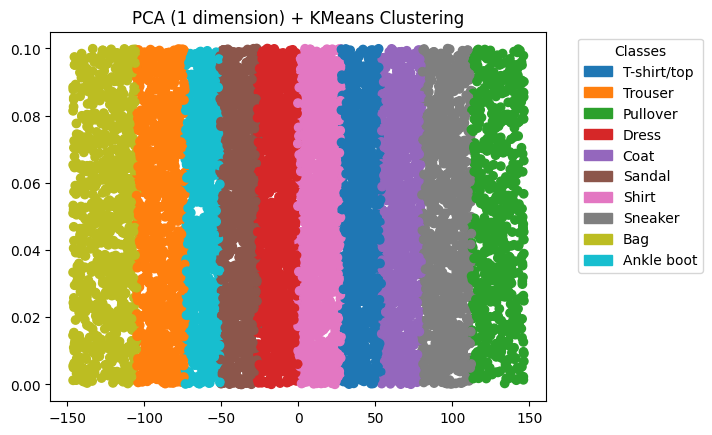

Silhouette Score for PCA (1 dimension) + KMeans: 0.5275288042040708


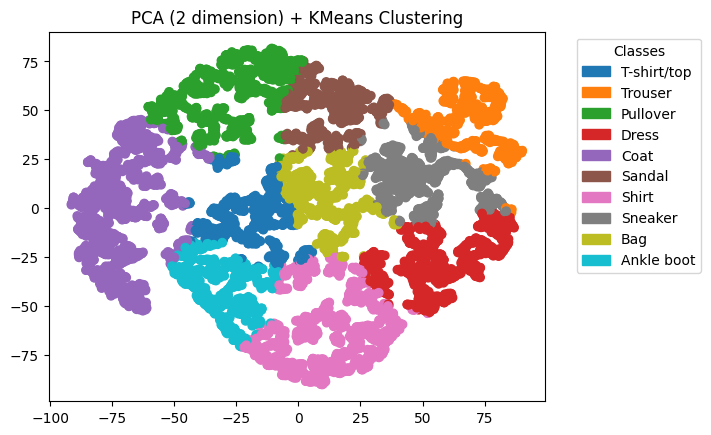

Silhouette Score for PCA (2 dimension) + KMeans: 0.4041378603177661


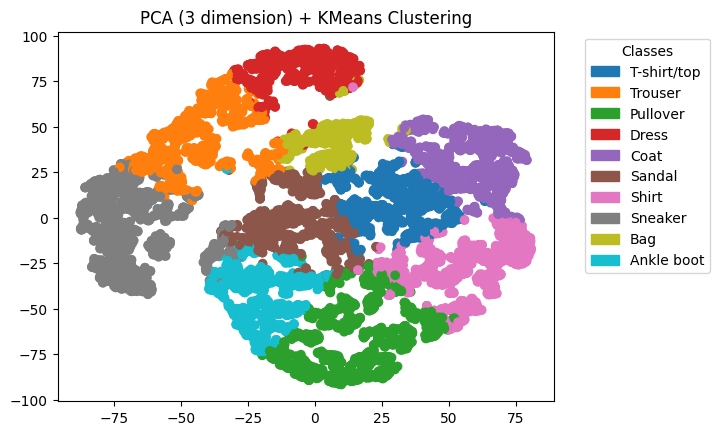

Silhouette Score for PCA (3 dimension) + KMeans: 0.3664816581467423


In [6]:
dims = [1, 2, 3]

for dim in dims:
  pca = PCA(n_components=dim)
  train_pca = pca.fit(X_flattened) # <---- train sample
  test_pca = pca.transform(valid_set) # <---- test sample

  kmeans = KMeans(n_clusters=10)
  pca_clusters = kmeans.fit_predict(test_pca)

  # Visual of PCA clusters with t-SNE
  if dim >= 2:
      X_tsne = TSNE(n_components=2).fit_transform(test_pca)
      plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=pca_clusters, cmap='tab10')
      legend_patches = [mpatches.Patch(color=plt.cm.tab10(i / 10), label=classes[i]) for i in range(10)]
      plt.legend(handles=legend_patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
  else:
    X_tsne = TSNE(n_components=dim).fit_transform(test_pca)
    y_jittered = np.random.rand(X_tsne.shape[0]) * 0.1
    plt.scatter(X_tsne[:, 0], y_jittered, c=pca_clusters, cmap='tab10')
    legend_patches = [mpatches.Patch(color=plt.cm.tab10(i / 10), label=classes[i]) for i in range(10)]
    plt.legend(handles=legend_patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

  plt.title(f'PCA ({dim} dimension) + KMeans Clustering')
  plt.show()

  print(f"Silhouette Score for PCA ({dim} dimension) + KMeans:", silhouette_score(test_pca, pca_clusters))

### Autoencoder

In [7]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvAutoencoder, self).__init__()


        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),                      # 7x7 -> 1x1 (latent space)
            nn.Flatten(),                              # Flatten to 64-dimensional vector
            nn.Linear(64, latent_dim)                          # Reduce to 3-dimensional latent space
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),                         # Map back to 64 dimensions
            nn.Unflatten(1, (64, 1, 1)),               # Reshape to (64, 1, 1)
            nn.ConvTranspose2d(64, 32, 7),             # 1x1 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # 14x14 -> 28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return latent, output

In [8]:
def train_loop(model, num_epoch):
  model.train()
  # Train loop
  for epoch in range(num_epoch):
      for data, _ in train_loader:
          inputs = data.view([-1, 1, 28, 28])
          latent, outputs = model(inputs)
          loss = criterion(outputs, inputs)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      print(f"Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item():.4f}")
  return model



def get_latent_representations(model, data_loader):
    model.eval()  # evaluation mode
    latent_representations = []
    with torch.no_grad():
        for data, _ in valid_loader:
            # pass data through encoder only for latent representation (output of encoder)
            latent, _ = model(data)
            latent_representations.append(latent)

    # Concatenate all batches into a single tensor
    latent_representations = torch.cat(latent_representations, dim=0)
    return latent_representations

Epoch [1/5], Loss: 0.6555
Epoch [2/5], Loss: 0.6413
Epoch [3/5], Loss: 0.6460
Epoch [4/5], Loss: 0.5971
Epoch [5/5], Loss: 0.6692



Latent representation shape: torch.Size([10000, 1])


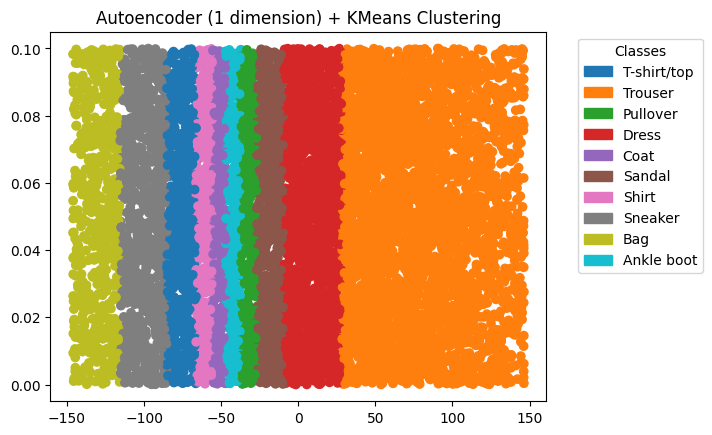

Silhouette Score for 1_dimensional latent representation Autoencoder + KMeans: 0.633551



Epoch [1/5], Loss: 0.6184
Epoch [2/5], Loss: 0.6229
Epoch [3/5], Loss: 0.6226
Epoch [4/5], Loss: 0.6040
Epoch [5/5], Loss: 0.6024



Latent representation shape: torch.Size([10000, 2])


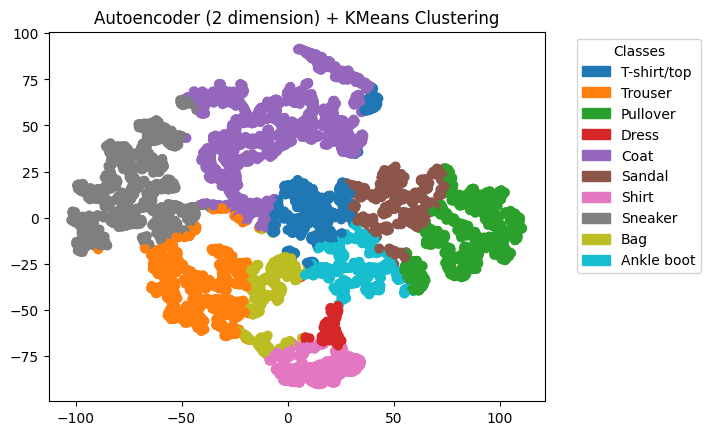

Silhouette Score for 2_dimensional latent representation Autoencoder + KMeans: 0.41320902



Epoch [1/5], Loss: 0.6615
Epoch [2/5], Loss: 0.6942
Epoch [3/5], Loss: 0.6933
Epoch [4/5], Loss: 0.7018
Epoch [5/5], Loss: 0.6548



Latent representation shape: torch.Size([10000, 3])


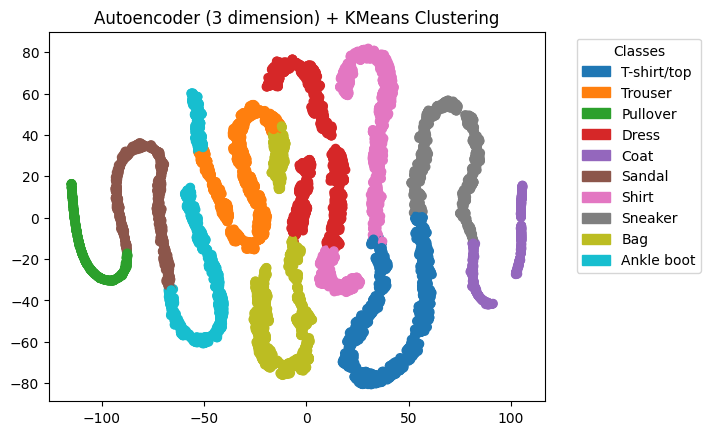

Silhouette Score for 3_dimensional latent representation Autoencoder + KMeans: 0.52128214





In [10]:
import numpy as np
latent_dims = [1, 2, 3]

for latent_dim in latent_dims:
  model = ConvAutoencoder(latent_dim)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  model = train_loop(model, num_epoch = 5)

  latent_representations = get_latent_representations(model, valid_loader)
  print("\n\n")
  print(f"Latent representation shape: {latent_representations.shape}")

  # visualize
  kmeans = KMeans(n_clusters=10)
  ae_clusters = kmeans.fit_predict(latent_representations)

  # Visualize Autoencoder Clusters with t-SNE
  if latent_dim >= 2:
      X_tsne = TSNE(n_components=2).fit_transform(latent_representations)
      plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=ae_clusters, cmap='tab10')
      legend_patches = [mpatches.Patch(color=plt.cm.tab10(i / 10), label=classes[i]) for i in range(10)]
      plt.legend(handles=legend_patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
  else:
    X_tsne = TSNE(n_components=latent_dim).fit_transform(latent_representations)
    y_jittered = np.random.rand(X_tsne.shape[0]) * 0.1
    plt.scatter(X_tsne[:, 0], y_jittered, c=ae_clusters, cmap='tab10')
    legend_patches = [mpatches.Patch(color=plt.cm.tab10(i / 10), label=classes[i]) for i in range(10)]
    plt.legend(handles=legend_patches, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

  plt.title(f'Autoencoder ({latent_dim} dimension) + KMeans Clustering')
  plt.show()

  print(f"Silhouette Score for {latent_dim}_dimensional latent representation Autoencoder + KMeans:", silhouette_score(latent_representations, ae_clusters))
  print('\n\n')

Reference

- [Ariel Felices kaggle tutorial](https://www.kaggle.com/code/arielfelices/dimensionality-reduction-using-an-autoencoder)
- ChatGPT